## What is a time series problem?

Time series problems deal with data over time.

Such as, the number of staff members in a company over 10-years, sales of computers for the past 5-years, electricity usage for the past 50-years.

The timeline can be short (seconds/minutes) or long (years/decades). And the problems you might investigate using can usually be broken down into two categories.

## check for GPU

In [1]:
# check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-feb1582e-5482-d5b7-a448-dd8008705717)


## Get data

In [2]:
# Download Bitcoin historical data from GitHub 
# Note: you'll need to select "Raw" to download the data in the correct format
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv 

--2023-03-26 11:14:14--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.01s   

2023-03-26 11:14:14 (12.6 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



### Importing time series data with pandas

In [3]:
# Import with pandas 
import pandas as pd
# Parse dates and set date column to index
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", 
                 parse_dates=["Date"], 
                 index_col=["Date"]) # parse the date column (tell pandas column 1 is a datetime)
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
# How many samples do we have?
len(df)

2787

In [6]:
# Only want closing price for each day 
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


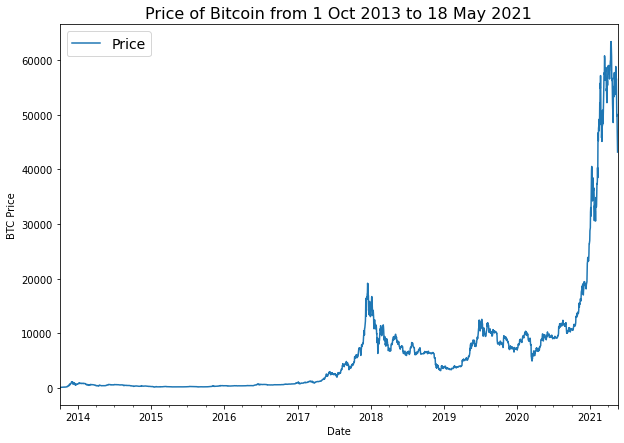

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

### Importing time series data with Python's CSV module

In [8]:
# importing and formatting historical bitcon data with python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",") # read in the target CSV
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not strings), strptime = string parse time
    btc_price.append(float(line[2])) # get the closing price as float

# View first 10 of each
timesteps[:10], btc_price[:10]
     

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

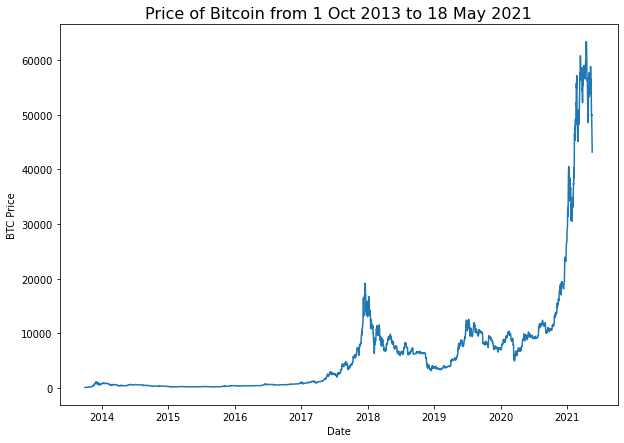

In [9]:
# Plot from CSV
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date")
plt.ylabel("BTC Price");

## Format Data Part 1: Creatining train and test sets for time series data


* Univariate time series data deals with one variable, for example, using the price of Bitcoin to predict the price of Bitcoin.
* Multivariate time series data deals with more than one variable, for example, predicting electricity demand using the day of week, time of year and number of houses in a region.

### Create train & test sets for time series (the wrong way)


In [10]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [11]:
# Wrong way to make train/test sets for time series
from sklearn.model_selection import train_test_split 

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # prices
                                                    test_size=0.2,
                                                    random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape 

((2229,), (558,), (2229,), (558,))

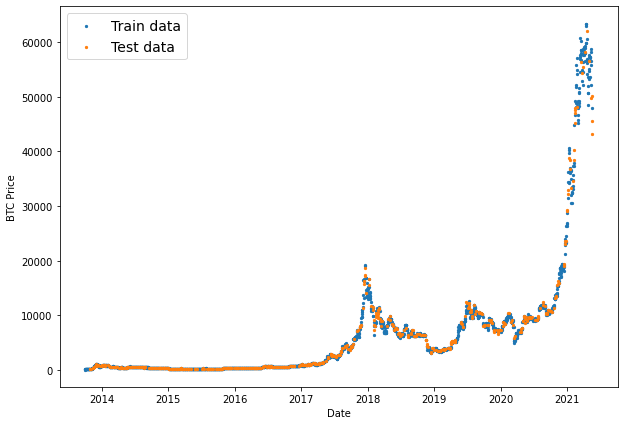

In [12]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train & test sets for time series (the right way)

In [13]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

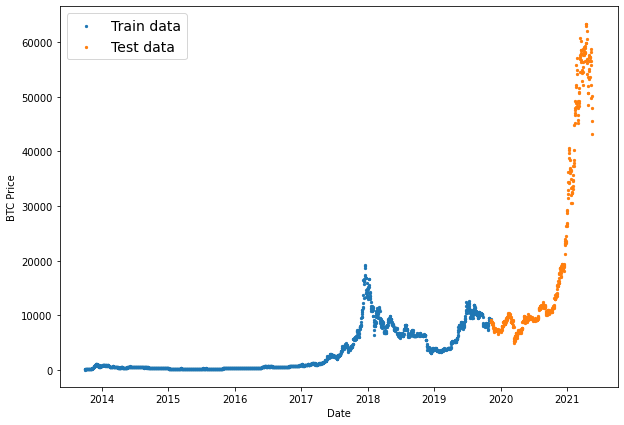

In [14]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create a plotting function

In [15]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
  """
  Plots a timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---------
  timesteps : array of timesteps
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will index from start of timesteps & values)
  end : where to end the plot (setting a value will index from end of timesteps & values)
  label : label to show on plot of values
  """
  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label:
    plt.legend(fontsize=14) # make label bigger
  plt.grid(True)

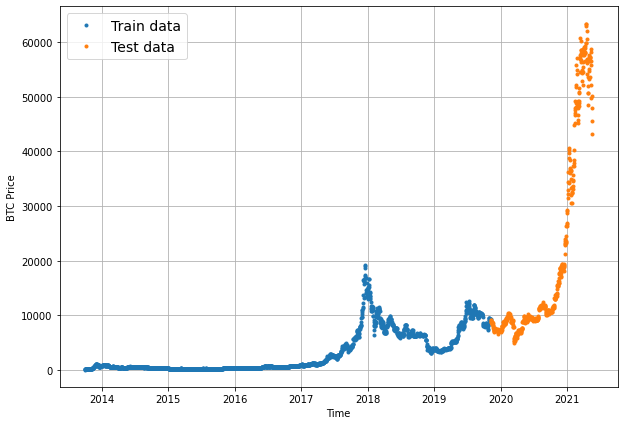

In [16]:
# Try out our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments
there are two terms you should be familiar with, horizon and window.

    horizon = number of timesteps to predict into future
    window = number of timesteps from past used to predict horizon


## Model 0: Naïve forecast (baseline)
One of the most common baseline models for time series forecasting, the naïve model (also called the naïve forecast), requires no training at all.

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (the previous timestep).

In [17]:
# Create a naïve forecast
naive_forecast = y_test[:-1] # Naïve forecast equals every value excluding the last value
naive_forecast[:10], naive_forecast[-10:] # View frist 10 and last 10 
  

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

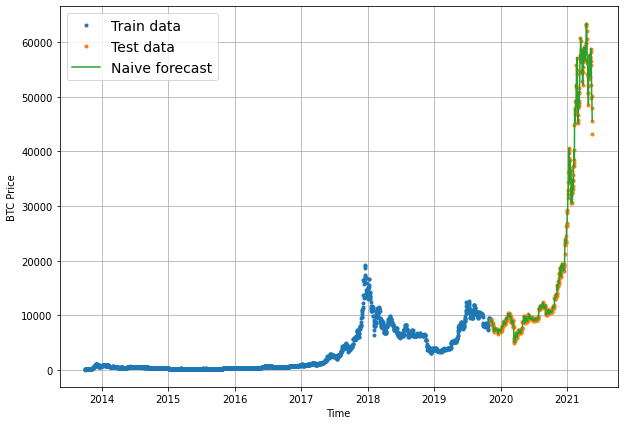

In [18]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", label="Naive forecast");
   

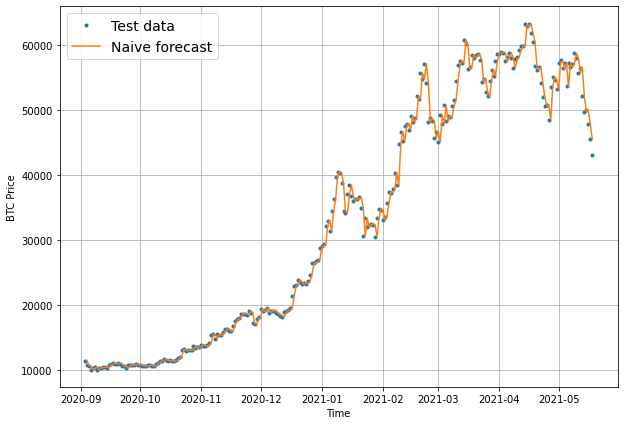

In [19]:
plt.figure(figsize=(10, 7))
offset = 300 # offset the values by 300 timesteps 
plot_time_series(timesteps=X_test, values=y_test, start=offset, label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format="-", start=offset, label="Naive forecast");
     

## Evaluating a time series model

### Scale-dependent errors

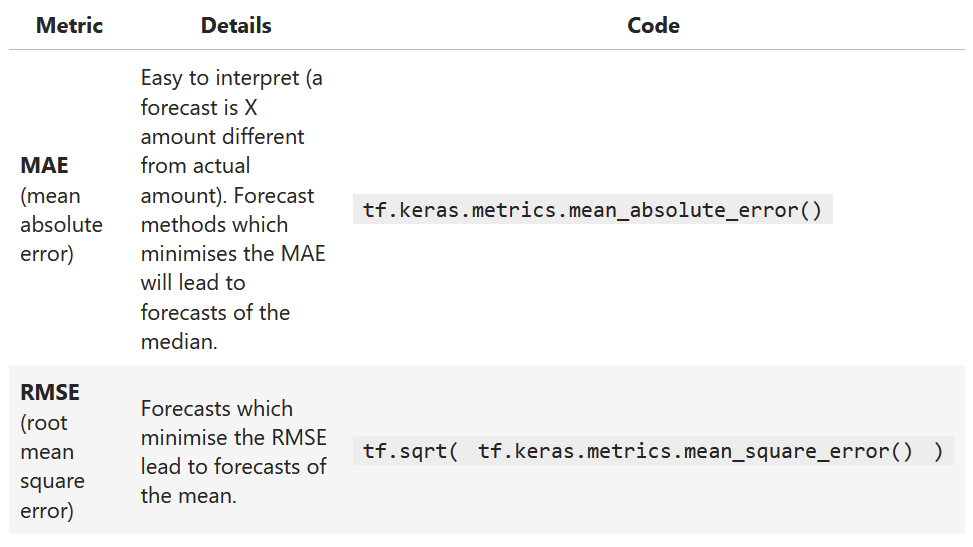


### Percentage errors

Percentage errors do not have units, this means they can be used to compare forecasts across different datasets.

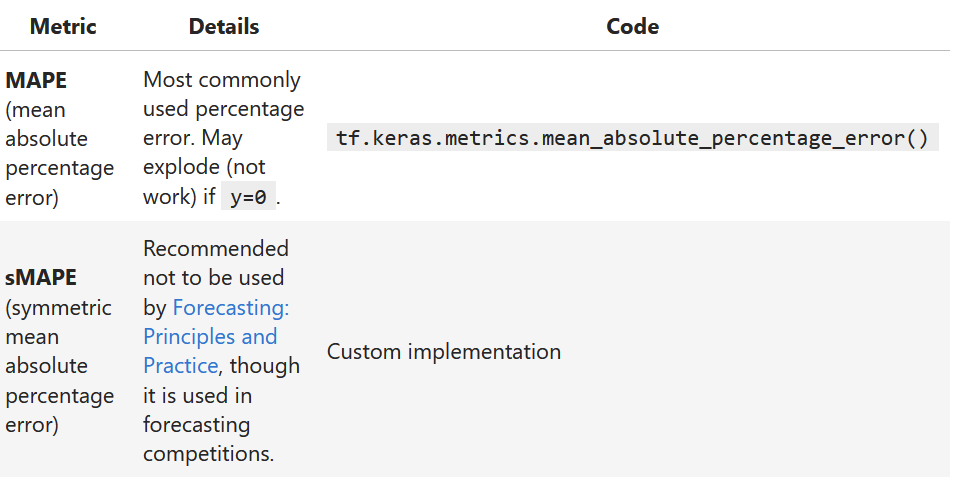


### Scaled errors

Scaled errors are an alternative to percentage errors when comparing forecast performance across different time series.

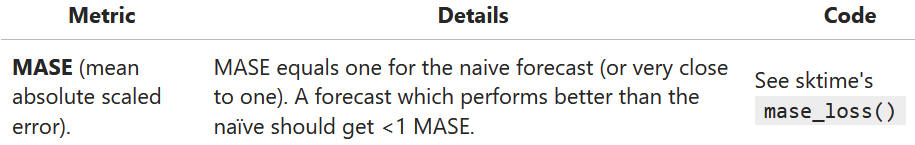


In [20]:
# Let's get TensorFlow! 
import tensorflow as tf
     

In [21]:

# MASE implemented courtesy of sktime - https://github.com/alan-turing-institute/sktime/blob/ee7a06843a44f4aaec7582d847e36073a9ab0566/sktime/performance_metrics/forecasting/_functions.py#L16
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """
  mae = tf.reduce_mean(tf.abs(y_true - y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonality is 1 day (hence the shifting of 1 day)

  return mae / mae_naive_no_season

In [22]:
# Create a function to take in model predictions and truth values and truth values and return evaluation
def evaluate_preds(y_true, y_pred):
  # make sure float32 datatype (for metrics calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # calculate varsion evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
  rmse = tf.sqrt(mse)
  maps = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {"mae":mae.numpy(),
          "mse":mse.numpy(),
          "rmse":rmse.numpy(),
          "mape":maps.numpy(),
          "mase":mase.numpy()}

that one good looking evaluation function!
let's now see if it work...

In [23]:
naive_result = evaluate_preds(y_true=y_test[1:],
                              y_pred=naive_forecast)

In [24]:
naive_result

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

In [25]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [26]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737222>

In [27]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Format Data Part 2: Windowing our dataset

why do we window our time series dataset to turn our data into a supervised learning problem.
```
windowing for one week
[0, 1, 2, 3, 4, 5, 6] --> [7]
[1, 2, 3, 4, 5, 6, 7] --> [8]
[2, 3, 4, 5, 6, 7, 8] --> [9]
```


In [28]:
# what we want to do with our bitcoin data
print(f"we want to use:{btc_price[:7]} to predict this: {btc_price[7]}")

we want to use:[123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this: 123.033


In [29]:
# Let's setup global variable for window and horizon size 
HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of bitcion data to make the prediction

In [30]:
# create function to label windowed data
def get_labelled_window(x, horizon=HORIZON):
  """
  Create labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] --> Output: ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [31]:
# test out the window labelling function 
test_window, test_label = get_labelled_window(tf.expand_dims(tf.range(8), axis=0))
print(f"Window:{tf.squeeze(test_window).numpy()} --> Label: {tf.squeeze(test_label).numpy()}")

Window:[0 1 2 3 4 5 6] --> Label: 7


we've got a way to label our windowed data.

however, this only works on a small scale.

we need a way to do the above across our entire time series .

we would do this with oython loops, however, for large time series, that'd be quite lsow.

our function will:
1. create a window step of specific window size ( e.g. [0, 1, 2, 3, 4, 5, 6])
2. use numpy indexing to create a 2D array of multiple window steps, for example:

```
[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]
```

3. uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of bitcoin)
4. uses our `get_labelled_window()` function we create above to turn the window steps into windows with a specific horizon


In [32]:
import numpy as np
# Create function to view NumPy arrays as windows 
def make_windows(x, window_size=7, horizon=1):
  """
  Turns a 1D array into a 2D array of sequential windows of window_size.
  """
  # 1. Create a window of specific window_size (add the horizon on the end for later labelling)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
  # print(f"Window step:\n {window_step}")

  # 2. Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
  # print(f"Window indexes:\n {window_indexes[:3], window_indexes[-3:], window_indexes.shape}")

  # 3. Index on the target array (time series) with 2D array of multiple window steps
  windowed_array = x[window_indexes]

  # 4. Get the labelled windows
  windows, labels = get_labelled_window(windowed_array, horizon=horizon)

  return windows, labels

In [33]:
np.expand_dims(np.arange(8), axis=0)

array([[0, 1, 2, 3, 4, 5, 6, 7]])

In [34]:
make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

(array([[  123.65499   ,   125.455     ,   108.58483   , ...,
           121.33866   ,   120.65533   ,   121.795     ],
        [  125.455     ,   108.58483   ,   118.67466   , ...,
           120.65533   ,   121.795     ,   123.033     ],
        [  108.58483   ,   118.67466   ,   121.33866   , ...,
           121.795     ,   123.033     ,   124.049     ],
        ...,
        [58788.20967893, 58102.19142623, 55715.54665129, ...,
         52147.82118698, 49764.1320816 , 50032.69313676],
        [58102.19142623, 55715.54665129, 56573.5554719 , ...,
         49764.1320816 , 50032.69313676, 47885.62525472],
        [55715.54665129, 56573.5554719 , 52147.82118698, ...,
         50032.69313676, 47885.62525472, 45604.61575361]]),
 array([[  123.033     ],
        [  124.049     ],
        [  125.96116   ],
        ...,
        [47885.62525472],
        [45604.61575361],
        [43144.47129086]]))

In [35]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [36]:
# view the first 3 windows/labels
for i in range(3):
  print(f"window: {full_windows[i]} --> labels: {full_labels}")

window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] --> labels: [[  123.033     ]
 [  124.049     ]
 [  125.96116   ]
 ...
 [47885.62525472]
 [45604.61575361]
 [43144.47129086]]
window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] --> labels: [[  123.033     ]
 [  124.049     ]
 [  125.96116   ]
 ...
 [47885.62525472]
 [45604.61575361]
 [43144.47129086]]
window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] --> labels: [[  123.033     ]
 [  124.049     ]
 [  125.96116   ]
 ...
 [47885.62525472]
 [45604.61575361]
 [43144.47129086]]


In [37]:
# view the first 3 windows/labels
for i in range(3):
  print(f"window: {full_windows[i-3]} --> labels: {full_labels[i-3]}")

window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] --> labels: [47885.62525472]
window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] --> labels: [45604.61575361]
window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] --> labels: [43144.47129086]


## Turning windows into training and test sets

In [38]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [39]:
# make the train splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [40]:
# create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows,full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [41]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [42]:
# check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]),y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Beacuse our model's performance will fluctuale from experiment to experiment , we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model'sbest performances against the other models model's best performances.

for example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

In [43]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file
     

## Model 1: Dense model (windows = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* a single dense layer with 128 hidden units and Relu
* an ouput layer with linear activation (no activation)
* adam optimization and MAE loss function
* batch size of 128 (previously we've used 32)
* 100 epochs

* **Huperparameter** = values a machine learning practitioner can adjust themselves 
* **Parameters**= values a model learns on its own 

In [44]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear") # linear activation is the same as having no activation                        
], name="model_1_dense") # give the model a name so we can save it

# Compile model
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae"]) # we don't necessarily need this when the loss function is already MAE

# Fit model
model_1.fit(x=train_windows, # train windows of 7 timesteps of Bitcoin prices
            y=train_labels, # horizon value of 1 (using the previous 7 timesteps to predict next day)
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # create ModelCheckpoint callback to save best model
     

Epoch 1/100
13/18 [====================>.........] - ETA: 0s - loss: 998.9114 - mae: 998.9114    

18/18 [==============================] - 9s 87ms/step - loss: 856.1851 - mae: 856.1851 - val_loss: 2360.9819 - val_mae: 2360.9819
Epoch 2/100
13/18 [====================>.........] - ETA: 0s - loss: 265.3215 - mae: 265.3215

18/18 [==============================] - 1s 46ms/step - loss: 246.8984 - mae: 246.8984 - val_loss: 1041.6603 - val_mae: 1041.6603
Epoch 3/100
13/18 [====================>.........] - ETA: 0s - loss: 185.5313 - mae: 185.5313

18/18 [==============================] - 1s 49ms/step - loss: 181.6826 - mae: 181.6826 - val_loss: 969.0651 - val_mae: 969.0651
Epoch 4/100
12/18 [===================>..........] - ETA: 0s - loss: 183.5010 - mae: 183.5010

18/18 [==============================] - 1s 58ms/step - loss: 174.3098 - mae: 174.3098 - val_loss: 957.6481 - val_mae: 957.6481
Epoch 5/100
12/18 [===================>..........] - ETA: 0s - loss: 178.7874 - mae: 178.7874

18/18 [==============================] - 1s 61ms/step - loss: 171.7477 - mae: 171.7477 - val_loss: 928.6440 - val_mae: 928.6440
Epoch 6/100
12/18 [===================>..........] - ETA: 0s - loss: 164.9747 - mae: 164.9747

18/18 [==============================] - 2s 95ms/step - loss: 167.3035 - mae: 167.3035 - val_loss: 901.5953 - val_mae: 901.5953
Epoch 7/100
11/18 [=================>............] - ETA: 0s - loss: 169.8102 - mae: 169.8102

18/18 [==============================] - 1s 48ms/step - loss: 160.7147 - mae: 160.7147 - val_loss: 890.0359 - val_mae: 890.0359
Epoch 8/100
13/18 [====================>.........] - ETA: 0s - loss: 156.9232 - mae: 156.9232

18/18 [==============================] - 1s 62ms/step - loss: 156.0803 - mae: 156.0803 - val_loss: 849.8546 - val_mae: 849.8546
Epoch 9/100
13/18 [====================>.........] - ETA: 0s - loss: 154.2478 - mae: 154.2478

18/18 [==============================] - 2s 89ms/step - loss: 155.2499 - mae: 155.2499 - val_loss: 830.4370 - val_mae: 830.4370
Epoch 10/100
11/18 [=================>............] - ETA: 0s - loss: 146.8618 - mae: 146.8618

18/18 [==============================] - 2s 92ms/step - loss: 150.8969 - mae: 150.8969 - val_loss: 812.8754 - val_mae: 812.8754
Epoch 11/100
18/18 [==============================] - 0s 9ms/step - loss: 144.4777 - mae: 144.4777 - val_loss: 820.4489 - val_mae: 820.4489
Epoch 12/100
18/18 [==============================] - 0s 8ms/step - loss: 142.1691 - mae: 142.1691 - val_loss: 821.5330 - val_mae: 821.5330
Epoch 13/100
13/18 [====================>.........] - ETA: 0s - loss: 136.3552 - mae: 136.3552

18/18 [==============================] - 1s 53ms/step - loss: 140.7990 - mae: 140.7990 - val_loss: 803.8674 - val_mae: 803.8674
Epoch 14/100
 7/18 [==========>...................] - ETA: 0s - loss: 130.5843 - mae: 130.5843

18/18 [==============================] - 1s 40ms/step - loss: 135.5538 - mae: 135.5538 - val_loss: 763.7876 - val_mae: 763.7876
Epoch 15/100
 1/18 [>.............................] - ETA: 0s - loss: 133.9550 - mae: 133.9550

18/18 [==============================] - 1s 40ms/step - loss: 136.8300 - mae: 136.8300 - val_loss: 733.5536 - val_mae: 733.5536
Epoch 16/100
18/18 [==============================] - 0s 5ms/step - loss: 130.5720 - mae: 130.5720 - val_loss: 747.0513 - val_mae: 747.0513
Epoch 17/100
15/18 [========================>.....] - ETA: 0s - loss: 126.0252 - mae: 126.0252

18/18 [==============================] - 1s 56ms/step - loss: 128.3778 - mae: 128.3778 - val_loss: 721.2593 - val_mae: 721.2593
Epoch 18/100
 8/18 [============>.................] - ETA: 0s - loss: 138.6673 - mae: 138.6673

18/18 [==============================] - 1s 35ms/step - loss: 128.0646 - mae: 128.0646 - val_loss: 688.0808 - val_mae: 688.0808
Epoch 19/100
18/18 [==============================] - 0s 15ms/step - loss: 127.2169 - mae: 127.2169 - val_loss: 710.8301 - val_mae: 710.8301
Epoch 20/100
18/18 [==============================] - 0s 15ms/step - loss: 125.8047 - mae: 125.8047 - val_loss: 692.6534 - val_mae: 692.6534
Epoch 21/100
11/18 [=================>............] - ETA: 0s - loss: 129.5749 - mae: 129.5749

18/18 [==============================] - 1s 55ms/step - loss: 126.5273 - mae: 126.5273 - val_loss: 667.4182 - val_mae: 667.4182
Epoch 22/100
11/18 [=================>............] - ETA: 0s - loss: 133.8114 - mae: 133.8114

18/18 [==============================] - 1s 43ms/step - loss: 121.6801 - mae: 121.6801 - val_loss: 658.7530 - val_mae: 658.7530
Epoch 23/100
16/18 [=========================>....] - ETA: 0s - loss: 121.5768 - mae: 121.5768

18/18 [==============================] - 1s 65ms/step - loss: 122.4355 - mae: 122.4355 - val_loss: 658.7172 - val_mae: 658.7172
Epoch 24/100
12/18 [===================>..........] - ETA: 0s - loss: 122.7972 - mae: 122.7972

18/18 [==============================] - 1s 39ms/step - loss: 120.2076 - mae: 120.2076 - val_loss: 646.9917 - val_mae: 646.9917
Epoch 25/100
12/18 [===================>..........] - ETA: 0s - loss: 123.8974 - mae: 123.8974

18/18 [==============================] - 1s 50ms/step - loss: 118.6602 - mae: 118.6602 - val_loss: 641.0717 - val_mae: 641.0717
Epoch 26/100
12/18 [===================>..........] - ETA: 0s - loss: 117.1381 - mae: 117.1381

18/18 [==============================] - 1s 54ms/step - loss: 117.8781 - mae: 117.8781 - val_loss: 634.5189 - val_mae: 634.5189
Epoch 27/100
18/18 [==============================] - 0s 7ms/step - loss: 118.9776 - mae: 118.9776 - val_loss: 639.6241 - val_mae: 639.6241
Epoch 28/100
10/18 [===============>..............] - ETA: 0s - loss: 119.7124 - mae: 119.7124

18/18 [==============================] - 1s 65ms/step - loss: 116.7861 - mae: 116.7861 - val_loss: 625.8940 - val_mae: 625.8940
Epoch 29/100
18/18 [==============================] - 0s 8ms/step - loss: 115.1384 - mae: 115.1384 - val_loss: 643.0392 - val_mae: 643.0392
Epoch 30/100
18/18 [==============================] - 0s 12ms/step - loss: 122.9283 - mae: 122.9283 - val_loss: 634.6317 - val_mae: 634.6317
Epoch 31/100
18/18 [==============================] - 0s 13ms/step - loss: 119.0138 - mae: 119.0138 - val_loss: 629.9384 - val_mae: 629.9384
Epoch 32/100
12/18 [===================>..........] - ETA: 0s - loss: 118.6001 - mae: 118.6001

18/18 [==============================] - 1s 48ms/step - loss: 114.3508 - mae: 114.3508 - val_loss: 615.5436 - val_mae: 615.5436
Epoch 33/100
18/18 [==============================] - 0s 6ms/step - loss: 114.5341 - mae: 114.5341 - val_loss: 663.5707 - val_mae: 663.5707
Epoch 34/100
18/18 [==============================] - 0s 14ms/step - loss: 115.2234 - mae: 115.2234 - val_loss: 624.6637 - val_mae: 624.6637
Epoch 35/100
18/18 [==============================] - 0s 9ms/step - loss: 112.5292 - mae: 112.5292 - val_loss: 619.8407 - val_mae: 619.8407
Epoch 36/100
18/18 [==============================] - ETA: 0s - loss: 117.0297 - mae: 117.0297

18/18 [==============================] - 1s 49ms/step - loss: 117.0297 - mae: 117.0297 - val_loss: 603.0491 - val_mae: 603.0491
Epoch 37/100
18/18 [==============================] - 0s 8ms/step - loss: 114.3370 - mae: 114.3370 - val_loss: 629.4826 - val_mae: 629.4826
Epoch 38/100
18/18 [==============================] - 0s 7ms/step - loss: 116.1083 - mae: 116.1083 - val_loss: 641.5428 - val_mae: 641.5428
Epoch 39/100
 1/18 [>.............................] - ETA: 0s - loss: 130.4499 - mae: 130.4499

18/18 [==============================] - 1s 31ms/step - loss: 116.5368 - mae: 116.5368 - val_loss: 600.2865 - val_mae: 600.2865
Epoch 40/100
18/18 [==============================] - 0s 12ms/step - loss: 114.1744 - mae: 114.1744 - val_loss: 616.5225 - val_mae: 616.5225
Epoch 41/100
18/18 [==============================] - 0s 8ms/step - loss: 115.0556 - mae: 115.0556 - val_loss: 663.6113 - val_mae: 663.6113
Epoch 42/100
18/18 [==============================] - 0s 7ms/step - loss: 117.2884 - mae: 117.2884 - val_loss: 621.1198 - val_mae: 621.1198
Epoch 43/100
18/18 [==============================] - 0s 5ms/step - loss: 114.6036 - mae: 114.6036 - val_loss: 637.1807 - val_mae: 637.1807
Epoch 44/100
18/18 [==============================] - ETA: 0s - loss: 114.5632 - mae: 114.5632

18/18 [==============================] - 1s 46ms/step - loss: 114.5632 - mae: 114.5632 - val_loss: 589.9736 - val_mae: 589.9736
Epoch 45/100
18/18 [==============================] - 0s 8ms/step - loss: 110.0964 - mae: 110.0964 - val_loss: 595.3558 - val_mae: 595.3558
Epoch 46/100
 1/18 [>.............................] - ETA: 0s - loss: 85.2841 - mae: 85.2841

18/18 [==============================] - 1s 35ms/step - loss: 111.5055 - mae: 111.5055 - val_loss: 587.4306 - val_mae: 587.4306
Epoch 47/100
18/18 [==============================] - 0s 5ms/step - loss: 111.6013 - mae: 111.6013 - val_loss: 637.1016 - val_mae: 637.1016
Epoch 48/100
18/18 [==============================] - 0s 7ms/step - loss: 109.6949 - mae: 109.6949 - val_loss: 608.6768 - val_mae: 608.6768
Epoch 49/100
18/18 [==============================] - 0s 9ms/step - loss: 111.3363 - mae: 111.3363 - val_loss: 643.2490 - val_mae: 643.2490
Epoch 50/100
13/18 [====================>.........] - ETA: 0s - loss: 114.5133 - mae: 114.5133

18/18 [==============================] - 1s 40ms/step - loss: 117.1005 - mae: 117.1005 - val_loss: 584.8071 - val_mae: 584.8071
Epoch 51/100
18/18 [==============================] - 0s 8ms/step - loss: 112.9871 - mae: 112.9871 - val_loss: 593.8686 - val_mae: 593.8686
Epoch 52/100
18/18 [==============================] - 0s 8ms/step - loss: 114.4447 - mae: 114.4447 - val_loss: 615.6656 - val_mae: 615.6656
Epoch 53/100
18/18 [==============================] - 0s 6ms/step - loss: 116.0599 - mae: 116.0599 - val_loss: 627.3889 - val_mae: 627.3889
Epoch 54/100
18/18 [==============================] - 0s 6ms/step - loss: 114.6740 - mae: 114.6740 - val_loss: 618.5325 - val_mae: 618.5325
Epoch 55/100
12/18 [===================>..........] - ETA: 0s - loss: 118.5441 - mae: 118.5441

18/18 [==============================] - 1s 60ms/step - loss: 112.1843 - mae: 112.1843 - val_loss: 579.8187 - val_mae: 579.8187
Epoch 56/100
18/18 [==============================] - 0s 8ms/step - loss: 109.1940 - mae: 109.1940 - val_loss: 807.8423 - val_mae: 807.8423
Epoch 57/100
18/18 [==============================] - 0s 9ms/step - loss: 131.5886 - mae: 131.5886 - val_loss: 815.2787 - val_mae: 815.2787
Epoch 58/100
18/18 [==============================] - 0s 5ms/step - loss: 128.8127 - mae: 128.8127 - val_loss: 700.9433 - val_mae: 700.9432
Epoch 59/100
18/18 [==============================] - 0s 6ms/step - loss: 109.8834 - mae: 109.8834 - val_loss: 602.3998 - val_mae: 602.3998
Epoch 60/100
18/18 [==============================] - 0s 9ms/step - loss: 111.3802 - mae: 111.3802 - val_loss: 642.6389 - val_mae: 642.6389
Epoch 61/100
18/18 [==============================] - 0s 13ms/step - loss: 110.4470 - mae: 110.4470 - val_loss: 582.4581 - val_mae: 582.4581
Epoch 62/100
18/18 [===========

18/18 [==============================] - 1s 36ms/step - loss: 109.9222 - mae: 109.9222 - val_loss: 578.2892 - val_mae: 578.2892
Epoch 66/100
12/18 [===================>..........] - ETA: 0s - loss: 104.7566 - mae: 104.7566

18/18 [==============================] - 1s 57ms/step - loss: 107.5839 - mae: 107.5839 - val_loss: 576.1550 - val_mae: 576.1550
Epoch 67/100
18/18 [==============================] - 0s 13ms/step - loss: 107.2803 - mae: 107.2803 - val_loss: 688.3033 - val_mae: 688.3033
Epoch 68/100
18/18 [==============================] - 0s 8ms/step - loss: 114.6226 - mae: 114.6226 - val_loss: 724.5060 - val_mae: 724.5060
Epoch 69/100
18/18 [==============================] - 0s 7ms/step - loss: 127.0524 - mae: 127.0524 - val_loss: 647.7936 - val_mae: 647.7936
Epoch 70/100
18/18 [==============================] - 0s 13ms/step - loss: 125.6367 - mae: 125.6367 - val_loss: 581.1493 - val_mae: 581.1493
Epoch 71/100
18/18 [==============================] - 0s 7ms/step - loss: 113.2875 - mae: 113.2875 - val_loss: 607.8699 - val_mae: 607.8699
Epoch 72/100
16/18 [=========================>....] - ETA: 0s - loss: 106.9012 - mae: 106.9012

18/18 [==============================] - 1s 49ms/step - loss: 108.7411 - mae: 108.7411 - val_loss: 572.1831 - val_mae: 572.1831
Epoch 73/100
18/18 [==============================] - 0s 9ms/step - loss: 110.2932 - mae: 110.2932 - val_loss: 589.0995 - val_mae: 589.0995
Epoch 74/100
18/18 [==============================] - 0s 7ms/step - loss: 107.7591 - mae: 107.7591 - val_loss: 597.0765 - val_mae: 597.0765
Epoch 75/100
18/18 [==============================] - 0s 5ms/step - loss: 109.9947 - mae: 109.9947 - val_loss: 601.4398 - val_mae: 601.4398
Epoch 76/100
18/18 [==============================] - 0s 9ms/step - loss: 108.3713 - mae: 108.3713 - val_loss: 579.9760 - val_mae: 579.9760
Epoch 77/100
18/18 [==============================] - 0s 8ms/step - loss: 108.6241 - mae: 108.6241 - val_loss: 572.4237 - val_mae: 572.4237
Epoch 78/100
18/18 [==============================] - 0s 8ms/step - loss: 110.2732 - mae: 110.2732 - val_loss: 573.6805 - val_mae: 573.6805
Epoch 79/100
18/18 [============

18/18 [==============================] - 1s 38ms/step - loss: 107.5575 - mae: 107.5575 - val_loss: 569.7032 - val_mae: 569.7032
Epoch 87/100
18/18 [==============================] - 0s 5ms/step - loss: 105.3666 - mae: 105.3666 - val_loss: 579.3705 - val_mae: 579.3705
Epoch 88/100
18/18 [==============================] - 0s 8ms/step - loss: 107.2302 - mae: 107.2302 - val_loss: 580.3094 - val_mae: 580.3094
Epoch 89/100
18/18 [==============================] - 0s 8ms/step - loss: 106.8753 - mae: 106.8753 - val_loss: 572.7141 - val_mae: 572.7141
Epoch 90/100
18/18 [==============================] - 0s 8ms/step - loss: 105.4186 - mae: 105.4186 - val_loss: 587.5815 - val_mae: 587.5815
Epoch 91/100
 9/18 [==============>...............] - ETA: 0s - loss: 111.1900 - mae: 111.1900

18/18 [==============================] - 1s 39ms/step - loss: 106.8623 - mae: 106.8623 - val_loss: 569.1561 - val_mae: 569.1561
Epoch 92/100
18/18 [==============================] - 0s 10ms/step - loss: 108.0178 - mae: 108.0178 - val_loss: 594.9625 - val_mae: 594.9625
Epoch 93/100
18/18 [==============================] - 0s 8ms/step - loss: 117.0266 - mae: 117.0266 - val_loss: 669.1303 - val_mae: 669.1303
Epoch 94/100
18/18 [==============================] - 0s 7ms/step - loss: 111.8263 - mae: 111.8263 - val_loss: 585.7476 - val_mae: 585.7476
Epoch 95/100
 1/18 [>.............................] - ETA: 0s - loss: 136.1459 - mae: 136.1459

18/18 [==============================] - 1s 32ms/step - loss: 105.6420 - mae: 105.6420 - val_loss: 567.8651 - val_mae: 567.8651
Epoch 96/100
18/18 [==============================] - 0s 11ms/step - loss: 112.5379 - mae: 112.5379 - val_loss: 680.5294 - val_mae: 680.5294
Epoch 97/100
18/18 [==============================] - 0s 6ms/step - loss: 110.3065 - mae: 110.3065 - val_loss: 569.2057 - val_mae: 569.2057
Epoch 98/100
18/18 [==============================] - 0s 5ms/step - loss: 105.4821 - mae: 105.4821 - val_loss: 572.1271 - val_mae: 572.1271
Epoch 99/100
14/18 [======================>.......] - ETA: 0s - loss: 102.4182 - mae: 102.4182

18/18 [==============================] - 1s 43ms/step - loss: 106.9066 - mae: 106.9066 - val_loss: 567.0076 - val_mae: 567.0076
Epoch 100/100
18/18 [==============================] - 0s 5ms/step - loss: 113.3935 - mae: 113.3935 - val_loss: 653.0682 - val_mae: 653.0682


In [45]:
# evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 3ms/step - loss: 653.0682 - mae: 653.0682


[653.0682373046875, 653.0682373046875]

In [46]:
# Load in saved best performing model_1 and evaluate on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 567.0077 - mae: 567.0077


[567.0076904296875, 567.0076904296875]

## Making forecasts with a model (on the test dataset)

to make "forecasts" on the test dataset (note: these won't be actual forecasts, they're only psuedo forecasts because actual forecasts are into the future), let's write a function to:
1. Take in train model
2. takes in some input data (same kind of data the model was trained on)
3. passes the input data to the model's `predict()` method
4. returns the predictions

In [47]:
def make_preds(model, input_data):
  """
  Uses model to make predictions on input_data.

  Parameters
  ----------
  model: trained model 
  input_data: windowed input data (same kind of data model was trained on)

  Returns model predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [48]:
# Make prediction using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

18/18 [==============================] - 0s 2ms/step


(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8846.634, 8767.268, 9036.317, 8757.203, 8708.124, 8758.248,
        8662.219, 8509.705, 8454.035, 8522.155], dtype=float32)>)

In [49]:
# evaluate preds 
model_1_results =  evaluate_preds(y_true=tf.squeeze(test_labels),
                                  y_pred=model_1_preds)
model_1_results

{'mae': 567.00775,
 'mse': 1166101.1,
 'rmse': 1079.8616,
 'mape': 2.5331767,
 'mase': 0.9960756}

In [50]:
naive_result

{'mae': 567.9802,
 'mse': 1147547.0,
 'rmse': 1071.2362,
 'mape': 2.516525,
 'mase': 0.99957}

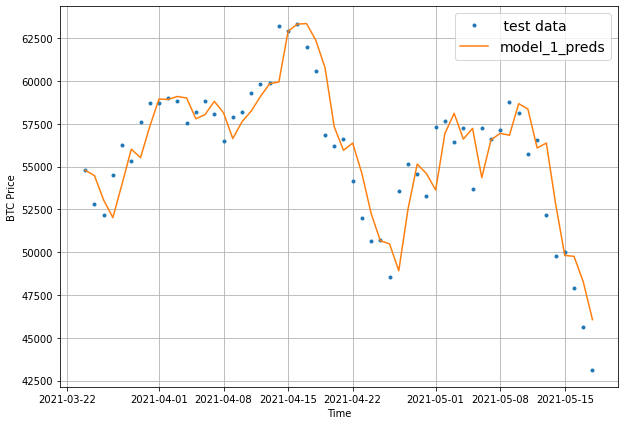

In [51]:
# let's plot our modle 1 predictions
offset =500
plt.figure(figsize=(10, 7))
# account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=test_labels[:,0],
                 start=offset,
                 label=" test data")

plot_time_series(timesteps=X_test[-len(test_windows):],
                 values=model_1_preds,
                 start=offset,
                 format="-",
                 label="model_1_preds")

## Model 2:Dense (windows =30, horizzon =1)


In [52]:
HORIZON = 1 # predict one step at a time (one day of bitcion prices)
WINDOW_SIZE = 30 # use 30 timesteps in past

In [53]:
# make windows data with appropriate horizon and windows size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows),len(full_labels)

(2757, 2757)

In [54]:
# make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                                labels=full_labels,
                                                                                test_split=0.2)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [55]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [56]:
tf.random.set_seed(42)

# create model
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name="model_2_dense")

# compile
model_2.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# fit 
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

In [57]:
# evaluate model 2 on test data
model_2.evaluate(test_windows,test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 632.2308


632.2308349609375

In [58]:
# load in the best performing model
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 626.7791


626.779052734375

In [59]:
# get forecast prediction 
model_2_preds = make_preds(model_2,
                          input_data=test_windows)

18/18 [==============================] - 0s 1ms/step


In [60]:
tf.squeeze(test_labels).shape, model_2_preds.shape

(TensorShape([552]), TensorShape([552]))

In [61]:
# evaluate result for model 2 predictions
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_2_preds)

In [62]:
model_2_results

{'mae': 626.77905,
 'mse': 1357349.4,
 'rmse': 1165.0533,
 'mape': 2.7886102,
 'mase': 1.095616}

In [63]:
model_1_results

{'mae': 567.00775,
 'mse': 1166101.1,
 'rmse': 1079.8616,
 'mape': 2.5331767,
 'mase': 0.9960756}

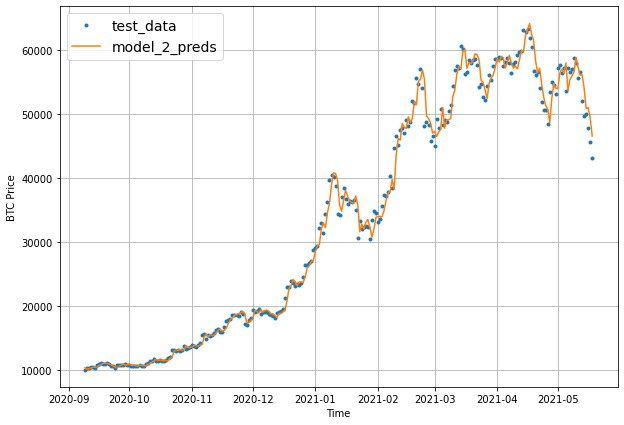

In [64]:
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_2_preds, start=offset, format="-", label="model_2_preds") 


## Model 3: Dense (windows = 30, horizon = 7)

In [65]:
prices[:10]

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  , 123.033  , 124.049  , 125.96116])

In [66]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2751, 2751)

In [67]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=full_windows,
                                                                               labels=full_labels)
len(train_windows),len(train_labels),len(test_windows), len(test_labels)

(2200, 2200, 551, 551)

In [68]:
tf.random.set_seed(42)

# create model (same as model_1 except with different data input and output sizes)
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dense(HORIZON)
], name = "model_3_dense")

# compile 
model_3.compile(loss="MAE",
                optimizer="Adam")

# fit
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            batch_size=128,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

In [69]:
# evaluate the model on the test data
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1339.6019


1339.6019287109375

In [70]:
# load in the best performing model
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1224.3529


1224.3529052734375

In [71]:
# get forecast prediction 
model_3_preds = make_preds(model_3,
                          input_data=test_windows)

18/18 [==============================] - 0s 2ms/step


In [72]:
# evaluate result for model 2 predictions
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)

In [73]:
model_3_results

{'mae': array([  598.93207 ,   301.22836 ,   329.34598 ,   559.3968  ,
          436.47867 ,   490.11264 ,   578.67804 ,   681.6489  ,
          633.12494 ,   565.35657 ,   796.07166 ,   888.2349  ,
          883.1714  ,   888.6918  ,   612.9517  ,   257.18988 ,
          195.89153 ,   262.9299  ,   153.34402 ,   225.68513 ,
          129.01877 ,   201.51674 ,   385.55838 ,   377.24185 ,
          238.4264  ,    91.72489 ,    97.215126,   115.708496,
          153.86607 ,   220.22356 ,   387.92877 ,   426.44223 ,
          360.57455 ,   374.63937 ,   330.68646 ,   270.53745 ,
          364.38162 ,   308.7173  ,   249.80588 ,   179.2115  ,
          397.2639  ,   101.415245,    48.45996 ,    79.61293 ,
          144.90096 ,   144.89676 ,   138.22859 ,   130.9719  ,
          105.26179 ,   162.0835  ,   128.13127 ,   169.8395  ,
          232.97726 ,   228.91518 ,   264.8067  ,   317.6972  ,
          511.7664  ,   456.28397 ,   461.33258 ,   506.56656 ,
          298.31683 ,   203.11928

## Make our evaluation function work for larger horizons

In [74]:

def evaluate_preds(y_true, y_pred):
  # Make sure float32 (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [75]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1224.3528,
 'mse': 5288585.5,
 'rmse': 1414.3541,
 'mape': 5.561237,
 'mase': 2.1786673}

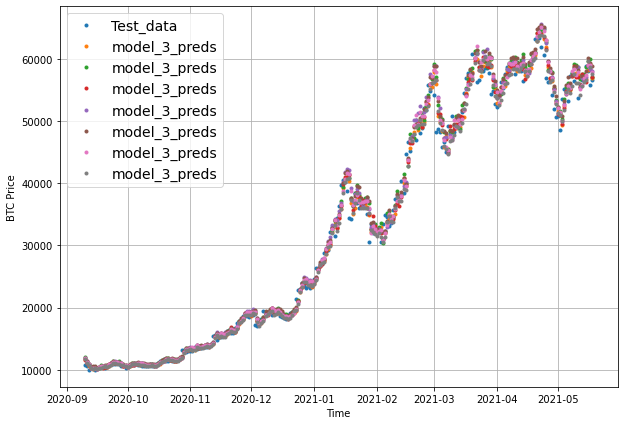

In [76]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(test_windows):], values=test_labels[:, 0], start=offset, label="Test_data")
# Checking the shape of model_3_preds results in [n_test_samples, HORIZON] (this will screw up the plot)
plot_time_series(timesteps=X_test[-len(test_windows):], values=model_3_preds, start=offset, label="model_3_preds")
     

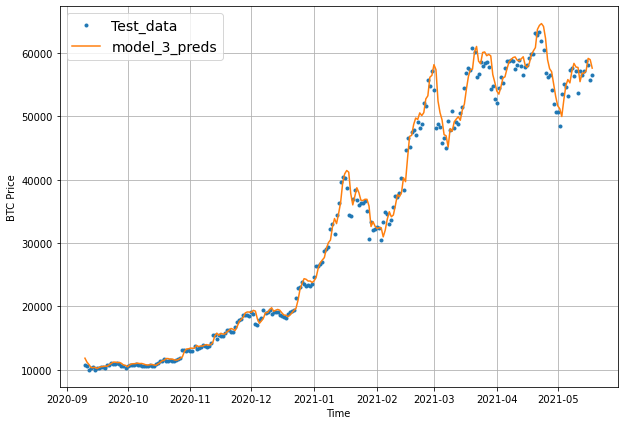

In [77]:
offset = 300
plt.figure(figsize=(10, 7))
# Plot model_3_preds by aggregating them (note: this condenses information so the preds will look fruther ahead than the test data)
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=test_labels[:, 0], 
                 start=offset, 
                 label="Test_data")
plot_time_series(timesteps=X_test[-len(test_windows):], 
                 values=tf.reduce_mean(model_3_preds, axis=1), 
                 format="-",
                 start=offset, 
                 label="model_3_preds")

## Which of our models is performing best so far?

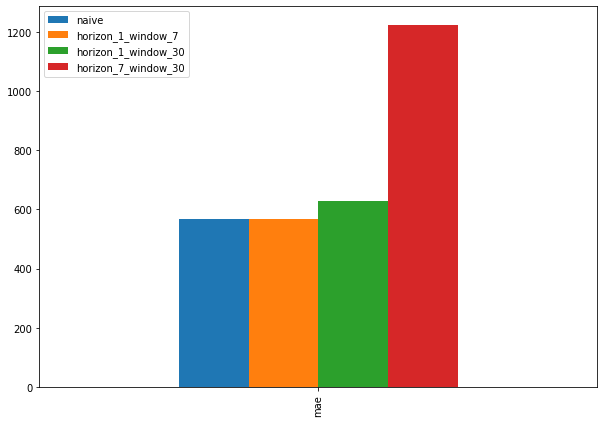

In [78]:
pd.DataFrame({"naive": naive_result["mae"], 
              "horizon_1_window_7": model_1_results["mae"], 
              "horizon_1_window_30": model_2_results["mae"], 
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");
     

## Model 4: Conv1D

In [79]:
HORIZON = 1 # predict next day
WINDOW_SIZE = 7 # use previous week worth of data

In [80]:
# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [81]:
# Create train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [82]:
# Check data sample shapes
train_windows[0].shape # returns (WINDOW_SIZE, )

(7,)

In [83]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make sure it works
x = tf.constant(train_windows[0])
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # add an extra dimension for timesteps
print(f"Original shape: {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim) 
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}")
 

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [84]:

tf.random.set_seed(42)

# Create model
model_4 = tf.keras.Sequential([
  # Create Lambda layer to reshape inputs, without this layer, the model will error
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)), # resize the inputs to adjust for window size / Conv1D 3D input requirements
  layers.Conv1D(filters=128, kernel_size=5, padding="causal", activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_conv1D")

# Compile model
model_4.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit model
model_4.fit(train_windows,
            train_labels,
            batch_size=128, 
            epochs=100,
            verbose=0,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])
     

In [85]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            4608      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [86]:
# Load in best performing Conv1D model and evaluate it on the test data
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 6ms/step - loss: 570.1128


570.11279296875

In [87]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

18/18 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8915.384, 8809.765, 9022.505, 8806.422, 8763.034, 8762.294,
       8705.345, 8547.107, 8489.311, 8536.874], dtype=float32)>

In [88]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_4_preds)
model_4_results
     

{'mae': 570.11273,
 'mse': 1183711.8,
 'rmse': 1087.9851,
 'mape': 2.5538933,
 'mase': 1.0015302}

## Model 5: RNN (LSTM)

In [89]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs) # expand input dimension to be compatible with LSTM
# print(x.shape)
# x = layers.LSTM(128, activation="relu", return_sequences=True)(x) # this layer will error if the inputs are not the right shape
x = layers.LSTM(128, activation="relu")(x) # using the tanh loss function results in a massive error
# print(x.shape)
# Add another optional dense layer (you could add more of these to see if they improve model performance)
# x = layers.Dense(32, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name="model_5_lstm")

# Compile model
model_5.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Seems when saving the model several warnings are appearing: https://github.com/tensorflow/tensorflow/issues/47554 
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=0,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

In [90]:
# Load in best version of model 5 and evaluate on the test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 4ms/step - loss: 598.8514


598.8513793945312

In [91]:
# Make predictions with our LSTM model
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8961.428, 8801.04 , 8938.034, 8793.717, 8747.343, 8732.206,
       8702.117, 8535.272, 8476.197, 8499.107], dtype=float32)>

In [92]:
# Evaluate model 5 preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_5_preds)
model_5_results

{'mae': 598.8514,
 'mse': 1274603.6,
 'rmse': 1128.9834,
 'mape': 2.7035263,
 'mase': 1.052016}

## make a multivariate time series dataset



In [93]:
# let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [94]:
# let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 january 2009 this block reward isn't in our dataset 
block_reward_2 = 25 # 8 nov 2012
block_reward_3 = 12.5 # 9 july 2016
block_reward_4 = 6.25 # 18 may 2020

# block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [95]:
# craete date range of where specific block_reward values shpuld be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [96]:
# add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


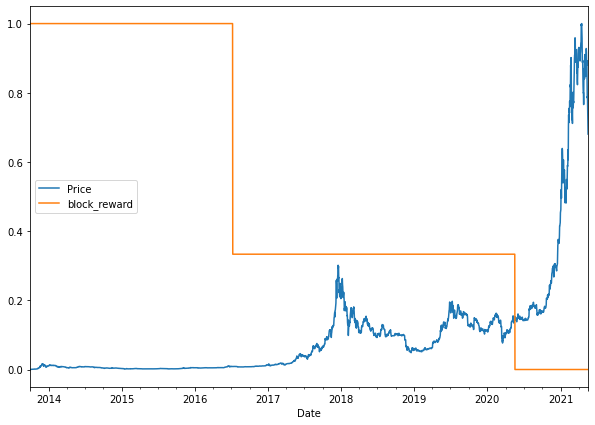

In [97]:

# Plot the block reward/price over time
# Note: Because of the different scales of our values we'll scale them to be between 0 and 1.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]), # we need to scale the data first
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7));
     
     

### Making a windowed dataset with pandas

In [98]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7
     

In [99]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE): # Shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods=i+1)
bitcoin_prices_windowed.head(10)


,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


Window for a week (7) to predict a horizon of 1 (multivariate time series)
WINDOW_SIZE & block_reward -> HORIZON
```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [100]:
# Let's create X & y, remove the NaN's and convert to float32 to prevent TensorFlow errors 
X = bitcoin_prices_windowed.dropna().drop("Price", axis=1).astype(np.float32) 
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [101]:
# View labels
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [102]:
# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

## Model 6: Dense (multivariate time series)

Model 6: Dense (multivariate time series)

To keep things simple, let's the model_1 architecture and use it to train and make predictions on our multivariate time series data.

In [103]:

tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  # layers.Dense(128, activation="relu"), # adding an extra layer here should lead to beating the naive model
  layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam())

# Fit
model_6.fit(X_train, y_train,
            epochs=100,
            batch_size=128,
            verbose=0, # only print 1 line per epoch
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

In [104]:
# Make sure best model is loaded and evaluate
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate")
model_6.evaluate(X_test, y_test)


18/18 [==============================] - 0s 5ms/step - loss: 566.0219


566.0218505859375

In [105]:
# Make predictions on multivariate data
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]


18/18 [==============================] - 0s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8820.219, 8783.965, 9004.037, 8720.225, 8755.767, 8708.01 ,
       8640.402, 8528.424, 8430.485, 8509.548], dtype=float32)>

In [106]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_6_preds)
model_6_results

{'mae': 566.02185,
 'mse': 1162289.1,
 'rmse': 1078.0951,
 'mape': 2.536843,
 'mase': 0.99434364}

In [107]:
model_1_results

{'mae': 567.00775,
 'mse': 1166101.1,
 'rmse': 1079.8616,
 'mape': 2.5331767,
 'mase': 0.9960756}

## Model 7: N-BEATS algorithm
So far we've tried a bunch of smaller models, models with only a couple of layers.

But one of the best ways to improve a model's performance is to increase the number of layers in it.
That's exactly what the N-BEATS (Neural Basis Expansion Analysis for Interpretable Time Series Forecasting) algorithm does.

tf.keras.layers.Layer

  * Creating a custom layer is helpful for when TensorFlow doesn't already have an existing implementation of a layer or if you'd like to make a layer configuration repeat a number of times (e.g. like a stack of N-BEATS blocks)


## Building and testing an N-BEATS block layer

In [108]:
# create NBeatsBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
  def __init__(self,# the constructor takes all the hyperparameters for the layer
               input_size: int,
               theta_size: int,
               horizon: int,
               n_neurons: int,
               n_layers: int,
               **kwargs): # the **kwargs argument takes care of all of the arguments for the parent class (input_shape, trainable, name)
   super().__init__(**kwargs)
   self.input_size = input_size
   self.theta_size = theta_size
   self.horizon = horizon
   self.n_neurons = n_neurons
   self.n_layers = n_layers
   # Block contains stack of 4 fully connected layers each has ReLU activation
   self.hidden = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
   # output of block is a theta layer with linear activation
   self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear")

  def call(self, inputs): # the call method is what runs when the layer is called 
    x = inputs
    for layer in self.hidden: # pass inputs through each hidden layer
      x = layer(x)
    theta = self.theta_layer(x)
    # output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast

let's test our NBeatsBlock class
to do we'll make some dummy inputs & output.

In [109]:
# set up dummy NBeatsBlock layer to represent inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                       theta_size=WINDOW_SIZE+HORIZON, # backcast + forecast
                                       horizon=HORIZON,
                                       n_neurons=128,
                                       n_layers=4)

In [110]:
#create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE)+1, axis=0) #input shape to the model has to reflect dense layer

In [111]:
# pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeats_block_layer(dummy_inputs)
# these are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"backcast:  {tf.squeeze(backcast.numpy())}")
print(f"forecast:  {tf.squeeze(forecast.numpy())}")

backcast:  [-0.70781916  0.01211959 -0.25157282  0.29186234 -0.21438773 -1.2647126
  0.16183454]
forecast:  0.2629045844078064


## Preparing data for the N-BEATS algorithm using tf.data

In [112]:
HORIZON = 1 # how far to predict forward
WINDOW_SIZE = 7 # how far to lookback
     

In [113]:
# Create NBEATS data inputs (NBEATS works with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [114]:
# Add windowed columns
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE):
  bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods=i+1)
bitcoin_prices_nbeats.dropna().head()

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500
2013-10-10,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483
2013-10-11,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866,118.67466
2013-10-12,125.92750,125.27966,125.96116,124.04900,123.03300,121.79500,120.65533,121.33866


In [115]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"]

# Make train and test sets
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [116]:
# 1. Turn train and test arrays into tensor Datasets
train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# 2. Combine features & labels
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset


(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>)

## Setting up hyperparameters for N-BEATS algorithm

In [117]:
# Values from N-BEATS paper Figure 1 and Table 18/Appendix D
N_EPOCHS = 5000 # called "Iterations" in Table 18
N_NEURONS = 512 # called "Width" in Table 18
N_LAYERS = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON # called "Lookback" in Table 18
THETA_SIZE = INPUT_SIZE + HORIZON

INPUT_SIZE, THETA_SIZE

(7, 8)

## Getting ready for residual connections

before we can craft our N-BEATS model, we need two layers for the residual connection (substract and add).

the n-bearts algorithm uses double residual stacking tp help train its deeper architecture

In [118]:
# make tensor
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# subtract 
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get output
print(f"Input tensors: {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"subtracted: {subtracted.numpy()}")
print(f"added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
subtracted: [10 10 10 10 10 10 10 10 10 10]
added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. setup an instance of the N-BEATS block layer using `NBeastBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)

2. ceate an input layer for the N-BEATS stack (we'll be using the keras functional API)

3. make the initial backcast and forecasts for the model with the layer create in (1)

4. use for loop to create stacks of block layers

5. use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcast and block-level forecasts.

6. create the double residual stacking using substarct and add layers.

7. put the model inputs and outputs togather using `tf.keras.Modle().

8. compile the model with MAE loss and adam optimizer with defult setting as per section  

9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs , we'll use couple of callbacks:
   * early stopping - beacuse the model will be training for so long , we'll stop it early if it stops improving
   * reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller steps towards best performance)

In [119]:
%%time

tf.random.set_seed(42)

# 1. Setup N-BEATS Block layer
nbeats_block_layer = NBeatsBlock(input_size=INPUT_SIZE,
                                 theta_size=THETA_SIZE,
                                 horizon=HORIZON,
                                 n_neurons=N_NEURONS,
                                 n_layers=N_LAYERS,
                                 name="InitialBlock")

# 2. Create input to stacks
stack_input = layers.Input(shape=(INPUT_SIZE), name="stack_input")

# 3. Create initial backcast and forecast input (backwards predictions are referred to as residuals in the paper)
backcast, forecast = nbeats_block_layer(stack_input)
# Add in subtraction residual link, thank you to: https://github.com/mrdbourke/tensorflow-deep-learning/discussions/174 
residuals = layers.subtract([stack_input, backcast], name=f"subtract_00") 

# 4. Create stacks of blocks
for i, _ in enumerate(range(N_STACKS-1)): # first stack is already creted in (3)

  # 5. Use the NBeatsBlock to calculate the backcast as well as block forecast
  backcast, block_forecast = NBeatsBlock(
      input_size=INPUT_SIZE,
      theta_size=THETA_SIZE,
      horizon=HORIZON,
      n_neurons=N_NEURONS,
      n_layers=N_LAYERS,
      name=f"NBeatsBlock_{i}"
  )(residuals) # pass it in residuals (the backcast)

  # 6. Create the double residual stacking
  residuals = layers.subtract([residuals, backcast], name=f"subtract_{i}") 
  forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
model_7 = tf.keras.Model(inputs=stack_input, 
                         outputs=forecast, 
                         name="model_7_N-BEATS")

# 8. Compile with MAE loss and Adam optimizer
model_7.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(0.001),
                metrics=["mae", "mse"])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
model_7.fit(train_dataset,
            epochs=N_EPOCHS,
            validation_data=test_dataset,
            verbose=0, # prevent large amounts of training outputs
            # callbacks=[create_model_checkpoint(model_name=stack_model.name)] # saving model every epoch consumes far too much time
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=200, restore_best_weights=True),
                      tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=100, verbose=1)])
     


Epoch 181: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 281: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
CPU times: user 2min 2s, sys: 1.9 s, total: 2min 4s
Wall time: 2min 35s


In [120]:
# Evaluate N-BEATS model on the test dataset
model_7.evaluate(test_dataset)

1/1 [==============================] - 0s 32ms/step - loss: 580.9926 - mae: 580.9926 - mse: 1184513.2500


[580.9926147460938, 580.9926147460938, 1184513.25]

In [121]:
# Make predictions with N-BEATS model
model_7_preds = make_preds(model_7, test_dataset)
model_7_preds[:10]
     

1/1 [==============================] - 2s 2s/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8928.505 , 8819.453 , 9003.698 , 8818.9375, 8809.894 , 8808.346 ,
       8661.329 , 8563.877 , 8527.899 , 8510.029 ], dtype=float32)>

In [122]:
# Evaluate N-BEATS model predictions
model_7_results = evaluate_preds(y_true=y_test,
                                 y_pred=model_7_preds)
model_7_results

{'mae': 580.9926,
 'mse': 1184513.2,
 'rmse': 1088.3534,
 'mape': 2.6651988,
 'mase': 1.0206431}

### Plotting the N-BEATS architecture we've created

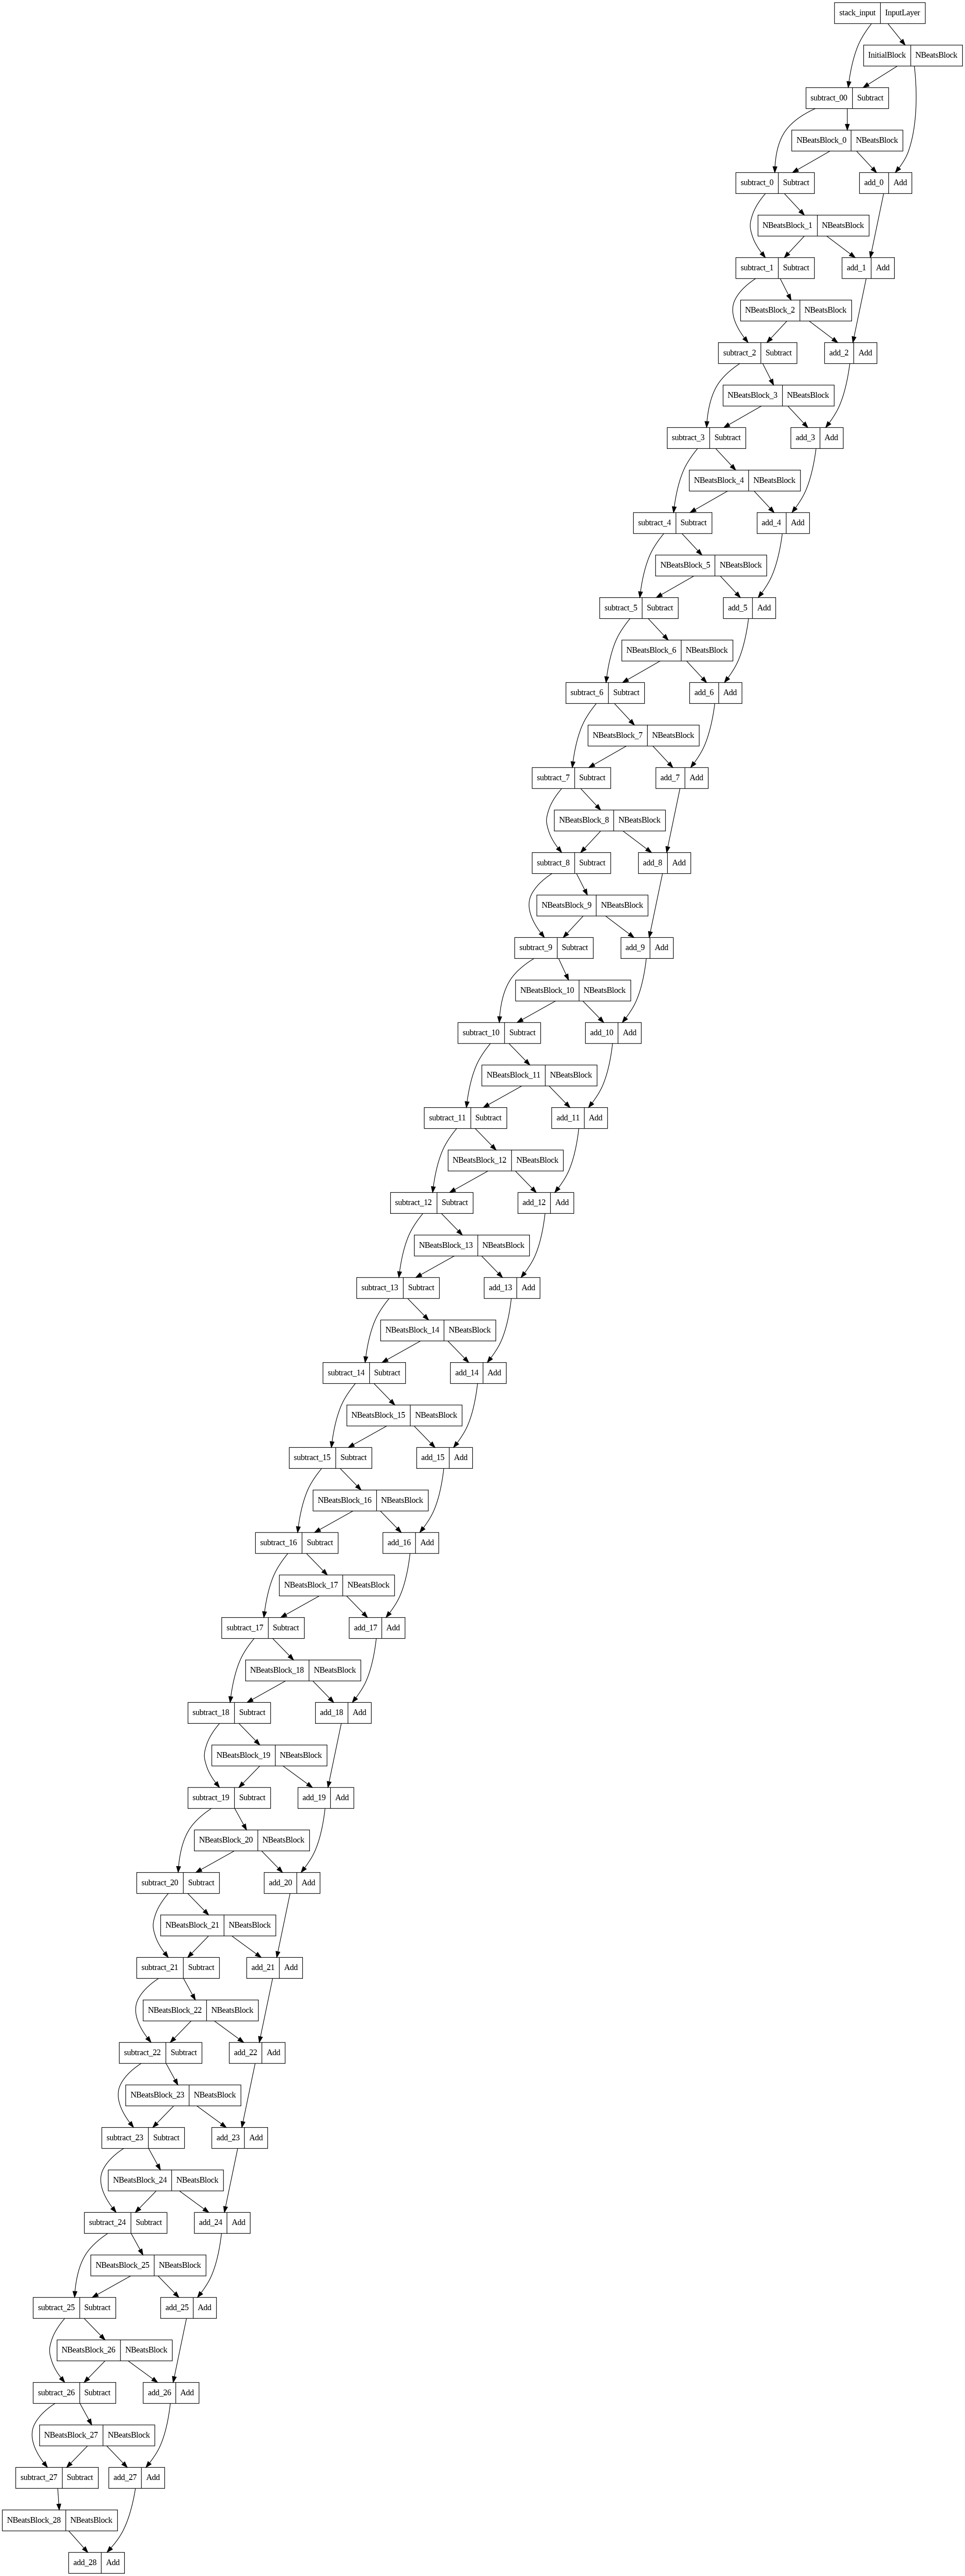

In [123]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model
plot_model(model_7)

## Model 8: Creating an ensemble (stacking different models together

An ensemble involves training and combining multiple different models on the same problem. Ensemble models are often the types of models you'll see winning data science competitions on websites like Kaggle.

 in the N-BEATS paper, they trained an ensemble of models (180 in total, see section 3.4) to achieve the results they did using a combination of:

*    Different loss functions (sMAPE, MASE and MAPE)
*   Different window sizes (2 x horizon, 3 x horizon, 4 x horizon...)

To create our ensemble models we're going to be using a combination of:

*    Different loss functions (MAE, MSE, MAPE)
*    Randomly initialized models



## constructing and fitting an ensemble of models (using different loss functions)

In [124]:
from keras.metrics.metrics import activations
def get_ensemble_models(horizon=HORIZON,
                        train_data=train_dataset,
                        test_data=test_dataset,
                        num_iter=10,
                        num_epochs=100,
                        loss_fns=["mae", "mse", "mape"]):
  """
  Returns a list of num_iter models each trained on MAE, MSE and MAPE loss.

  for example, if num_iter=10 a list of 30 trained models will be returned:
    10 * len(["mae", "mse", "mape"])
  """
  # make empty list for trained ensemble models
  ensemble_models = []

  # create num_iter number of models per loss function
  for i in range(num_iter):
    # Build and fit a new model with different loss function
    for loss_function in loss_fns:
      print(f"Optimizing model by reducing: {loss_function} for {num_epochs} epochs, model number: {i}")

      # construct a simple model (similar to model_1)
      model = tf.keras.Sequential([
       # Initialize layers with normal (Gaussian) distribution so we can use the models for prediction
       layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
       layers.Dense(128, kernel_initializer="he_normal", activation="relu"),
       layers.Dense(HORIZON)
      ])

      # Compile simple model with current loss function
      model.compile(loss=loss_function,
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=["mae", "mse"])
      
      # Fit model
      model.fit(train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                # Add callbacks to prevent training from going/stalling for too long
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor="val_loss",
                                                            patience=200,
                                                            restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                patience=100,
                                                                verbose=1)])
      
      # Append fitted model to list of ensemble models
      ensemble_models.append(model)

  return ensemble_models # return list of trained models


In [125]:
%%time
# Get list of trained ensemble models
ensemble_models = get_ensemble_models(num_iter=5,
                                      num_epochs=1000)

Optimizing model by reducing: mae for 1000 epochs, model number: 0
Optimizing model by reducing: mse for 1000 epochs, model number: 0

Epoch 415: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 515: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mape for 1000 epochs, model number: 0

Epoch 219: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 319: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mae for 1000 epochs, model number: 1

Epoch 716: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 816: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by reducing: mse for 1000 epochs, model number: 1

Epoch 717: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 817: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model by redu

## Making predictions with an ensemble model

In [126]:
# Create a function which uses a list of trained models to make and return a list of predictions
def make_ensemble_preds(ensemble_models, data):
  ensemble_preds = []
  for model in ensemble_models:
    preds = model.predict(data) # make predictions with current ensemble model
    ensemble_preds.append(preds)
  return tf.constant(tf.squeeze(ensemble_preds))

In [127]:
# Create a list of ensemble predictions
ensemble_preds = make_ensemble_preds(ensemble_models=ensemble_models,
                                     data=test_dataset)
ensemble_preds

1/1 [==============================] - 0s 49ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 39ms/step


<tf.Tensor: shape=(15, 556), dtype=float32, numpy=
array([[ 8738.756,  8703.276,  9033.494, ..., 49798.062, 48588.945,
        46070.688],
       [ 8768.414,  8754.744,  9047.908, ..., 49947.61 , 48008.742,
        45768.746],
       [ 8772.396,  8743.762,  9082.811, ..., 49358.465, 48302.105,
        46050.246],
       ...,
       [ 8756.503,  8779.692,  9084.833, ..., 50228.152, 48671.82 ,
        47345.61 ],
       [ 8797.164,  8769.854,  9090.405, ..., 49977.586, 48354.062,
        45975.61 ],
       [ 8865.647,  8844.228,  9106.399, ..., 50351.85 , 48198.508,
        45915.875]], dtype=float32)>

In [128]:
# Evaluate ensemble model(s) predictions
ensemble_results = evaluate_preds(y_true=y_test,
                                  y_pred=np.median(ensemble_preds, axis=0)) # take the median across all ensemble predictions
ensemble_results

{'mae': 568.7752,
 'mse': 1142458.0,
 'rmse': 1068.8583,
 'mape': 2.5748072,
 'mase': 0.9991805}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

One way of getting the 95% condfidnece prediction intervals for a deep learning model is the bootstrap method:

1.    Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble model)
2.    Measure the standard deviation of the predictions
3.    Multiply standard deviation by 1.96 (assuming the distribution is Gaussian, 95% of observations fall within 1.96 standard deviations of the mean, this is why we initialized our neural networks with a normal distribution)
4.    To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1)


In [130]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions of multiple randomly initialized deep learning neural networks
  
  # 2. Measure the standard deviation of the predictions
  std = tf.math.reduce_std(preds, axis=0)
  
  # 3. Multiply the standard deviation by 1.96
  interval = 1.96 * std 

  # 4. Get the prediction interval upper and lower bounds
  preds_mean = tf.reduce_mean(preds, axis=0)
  lower, upper = preds_mean - interval, preds_mean + interval
  return lower, upper

# Get the upper and lower bounds of the 95% 
lower, upper = get_upper_lower(preds=ensemble_preds)
     

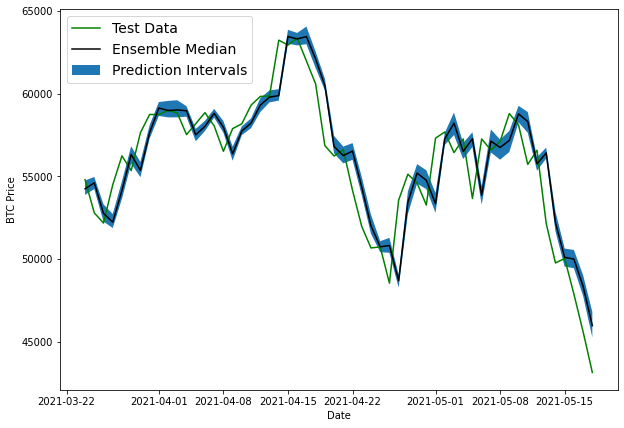

In [133]:
# Get the median values of our ensemble preds
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the median of our ensemble preds along with the prediction intervals (where the predictions fall between)
offset=500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test Data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble Median")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.fill_between(X_test.index[offset:], 
                 (lower)[offset:], 
                 (upper)[offset:], label="Prediction Intervals")
plt.legend(loc="upper left", fontsize=14);



We've just plotted:

*    The test data (the ground truth Bitcoin prices)
*    The median of the ensemble predictions
*   The 95% prediction intervals (assuming the data is Gaussian/normal, the model is saying that 95% of the time, predicted value should fall between this range

## Aside: two types of uncertainty (coconut and subway)

There are two types of uncertainty in machine learning you should be aware of:

*    Aleatoric uncertainty - this type of uncertainty cannot be reduced, it is also referred to as "data" or "subway" uncertainty.
* Epistemic uncertainty - this type of uncertainty can be reduced, it is also referred to as "model" or "coconut" uncertainty, it is very hard to calculate.

What levels of uncertainty do we have here?

From an aleatory uncertainty (data) point of view, no matter how many conversations of first dates you collect, the conversation you end up having will likely be different to the rest (the best conversations have no subject and appear random).

From an epistemic uncertainty (model) point of view, if the date is truly blind and both parties don't know who they're seeing until they meet in person, the epistemic uncertainty would be high. Because now you have no idea who the person you're going to meet is nor what you might talk about.

## Model 9: Train a model on the full historical data to make predictions into future

In [134]:
bitcoin_prices_windowed.head()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [135]:
# Train model on entire data to make prediction for the next day 
X_all = bitcoin_prices_windowed.drop(["Price", "block_reward"], axis=1).dropna().to_numpy() # only want prices, our future model can be a univariate model
y_all = bitcoin_prices_windowed.dropna()["Price"].to_numpy()



Windows and labels ready! Let's turn them into performance optimized TensorFlow Datasets by:

1.   Turning X_all and y_all into tensor Datasets using `tf.data.Dataset.from_tensor_slices()`
2.   Combining the features and labels into a Dataset tuple using` tf.data.Dataset.zip()`
3.   Batch and prefetch the data using `tf.data.Dataset.batch()` and `tf.data.Dataset.prefetch()` respectively



In [136]:
# 1. Turn X and y into tensor Datasets
features_dataset_all = tf.data.Dataset.from_tensor_slices(X_all)
labels_dataset_all = tf.data.Dataset.from_tensor_slices(y_all)

# 2. Combine features & labels
dataset_all = tf.data.Dataset.zip((features_dataset_all, labels_dataset_all))

# 3. Batch and prefetch for optimal performance
BATCH_SIZE = 1024 # taken from Appendix D in N-BEATS paper
dataset_all = dataset_all.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

dataset_all

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [137]:
tf.random.set_seed(42)

# Create model (nice and simple, just to test)
model_9 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON)
])

# Compile
model_9.compile(loss=tf.keras.losses.mae,
                optimizer=tf.keras.optimizers.Adam())

# Fit model on all of the data to make future forecasts
model_9.fit(dataset_all,
            epochs=100,
            verbose=0) # don't print out anything, we've seen this all before
     

### Make predictions on the future
 let's start by defining a variable INTO_FUTURE which decides how many timesteps we'd like to predict into the future.


In [138]:
# How many timesteps to predict into the future?
INTO_FUTURE = 14 # since our Bitcoin data is daily, this is for 14 days

o do so, we'll build the following steps:

1.    Function which takes as input:

*    a list of values (the Bitcoin historical data)
*    a trained model (such as model_9)
*    a window into the future to predict (our INTO_FUTURE variable)
*    the window size a model was trained on (WINDOW_SIZE) - the model can only predict on the same kind of data it was trained on

2.   Creates an empty list for future forecasts (this will be returned at the end of the function) and extracts the last WINDOW_SIZE values from the input values (predictions will start from the last WINDOW_SIZE values of the training data)
3.    Loop INTO_FUTURE times making a prediction on WINDOW_SIZE datasets which update to remove the first the value and append the latest prediction

*   Eventually future predictions will be made using the model's own previous predictions as input


In [139]:
# 1. Create function to make predictions into the future
def make_future_forecast(values, model, into_future, window_size=WINDOW_SIZE) -> list:
  """
  Makes future forecasts into_future steps after values ends.

  Returns future forecasts as list of floats.
  """
  # 2. Make an empty list for future forecasts/prepare data to forecast on
  future_forecast = []
  last_window = values[-WINDOW_SIZE:] # only want preds from the last window (this will get updated)

  # 3. Make INTO_FUTURE number of predictions, altering the data which gets predicted on each time 
  for _ in range(into_future):
    
    # Predict on last window then append it again, again, again (model starts to make forecasts on its own forecasts)
    future_pred = model.predict(tf.expand_dims(last_window, axis=0))
    print(f"Predicting on: \n {last_window} -> Prediction: {tf.squeeze(future_pred).numpy()}\n")
    
    # Append predictions to future_forecast
    future_forecast.append(tf.squeeze(future_pred).numpy())
    # print(future_forecast)

    # Update last window with new pred and get WINDOW_SIZE most recent preds (model was trained on WINDOW_SIZE windows)
    last_window = np.append(last_window, future_pred)[-WINDOW_SIZE:]
  
  return future_forecast

In [140]:
# Make forecasts into future of the price of Bitcoin
# Note: if you're reading this at a later date, you may already be in the future, so the forecasts 
# we're making may not actually be forecasts, if that's the case, readjust the training data.
future_forecast = make_future_forecast(values=y_all,
                                       model=model_9,
                                       into_future=INTO_FUTURE,
                                       window_size=WINDOW_SIZE)
     

1/1 [==============================] - 0s 108ms/step
Predicting on: 
 [56573.5554719  52147.82118698 49764.1320816  50032.69313676
 47885.62525472 45604.61575361 43144.47129086] -> Prediction: 55526.50390625

1/1 [==============================] - 0s 33ms/step
Predicting on: 
 [52147.82118698 49764.1320816  50032.69313676 47885.62525472
 45604.61575361 43144.47129086 55526.50390625] -> Prediction: 50922.38671875

1/1 [==============================] - 0s 74ms/step
Predicting on: 
 [49764.1320816  50032.69313676 47885.62525472 45604.61575361
 43144.47129086 55526.50390625 50922.38671875] -> Prediction: 49975.14453125

1/1 [==============================] - 0s 97ms/step
Predicting on: 
 [50032.69313676 47885.62525472 45604.61575361 43144.47129086
 55526.50390625 50922.38671875 49975.14453125] -> Prediction: 48572.953125

1/1 [==============================] - 0s 79ms/step
Predicting on: 
 [47885.62525472 45604.61575361 43144.47129086 55526.50390625
 50922.38671875 49975.14453125 48572.95

In [141]:
future_forecast[:10]

[55526.504,
 50922.387,
 49975.145,
 48572.953,
 46646.74,
 45412.547,
 47344.2,
 54269.023,
 50131.895,
 49374.902]

### Plot future forecasts
we'll use a combination of NumPy's datetime64 datatype (our Bitcoin dates are already in this datatype) as well as NumPy's timedelta64 method which helps to create date ranges.

In [142]:
def get_future_dates(start_date, into_future, offset=1):
  """
  Returns array of datetime values from ranging from start_date to start_date+horizon.

  start_date: date to start range (np.datetime64)
  into_future: number of days to add onto start date for range (int)
  offset: number of days to offset start_date by (default 1)
  """
  start_date = start_date + np.timedelta64(offset, "D") # specify start date, "D" stands for day
  end_date = start_date + np.timedelta64(into_future, "D") # specify end date
  return np.arange(start_date, end_date, dtype="datetime64[D]") # return a date range between start date and end date
 

In [143]:
# Last timestep of timesteps (currently in np.datetime64 format)
last_timestep = bitcoin_prices.index[-1]
last_timestep
     

Timestamp('2021-05-18 00:00:00')

In [144]:
# Get next two weeks of timesteps
next_time_steps = get_future_dates(start_date=last_timestep, 
                                   into_future=INTO_FUTURE)
next_time_steps

array(['2021-05-19', '2021-05-20', '2021-05-21', '2021-05-22',
       '2021-05-23', '2021-05-24', '2021-05-25', '2021-05-26',
       '2021-05-27', '2021-05-28', '2021-05-29', '2021-05-30',
       '2021-05-31', '2021-06-01'], dtype='datetime64[D]')

In [145]:
# Insert last timestep/final price so the graph doesn't look messed
next_time_steps = np.insert(next_time_steps, 0, last_timestep)
future_forecast = np.insert(future_forecast, 0, btc_price[-1])
next_time_steps, future_forecast

(array(['2021-05-18', '2021-05-19', '2021-05-20', '2021-05-21',
        '2021-05-22', '2021-05-23', '2021-05-24', '2021-05-25',
        '2021-05-26', '2021-05-27', '2021-05-28', '2021-05-29',
        '2021-05-30', '2021-05-31', '2021-06-01'], dtype='datetime64[D]'),
 array([43144.473, 55526.504, 50922.387, 49975.145, 48572.953, 46646.74 ,
        45412.547, 47344.2  , 54269.023, 50131.895, 49374.902, 47273.633,
        46157.598, 46372.61 , 49750.777], dtype=float32))

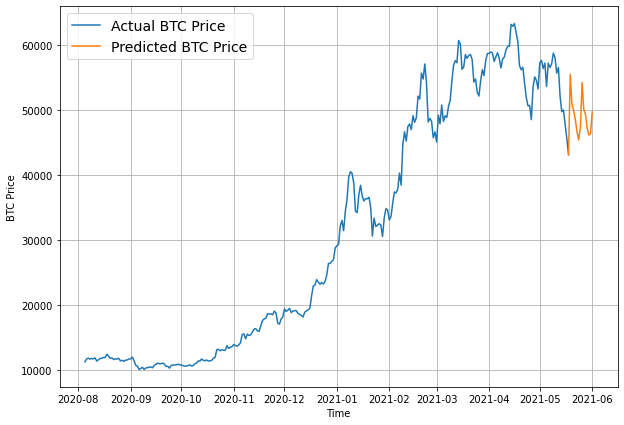

In [146]:
# Plot future price predictions of Bitcoin
plt.figure(figsize=(10, 7))
plot_time_series(bitcoin_prices.index, btc_price, start=2500, format="-", label="Actual BTC Price")
plot_time_series(next_time_steps, future_forecast, format="-", label="Predicted BTC Price")
    

## Model 10: Why forecasting is BS (the turkey problem 🦃)
The turkey problem is an analogy for when your observational data (your historical data) fails to capture a future event which is catostrophic and could lead you to ruin.


In [147]:
# Let's introduce a Turkey problem to our BTC data (price BTC falls 100x in one day)
btc_price_turkey = btc_price.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100

In [148]:
# Manufacture an extra price on the end (to showcase the Turkey problem)
btc_price_turkey[-10:]
     

[58788.2096789273,
 58102.1914262342,
 55715.5466512869,
 56573.5554719043,
 52147.8211869823,
 49764.1320815975,
 50032.6931367648,
 47885.6252547166,
 45604.6157536131,
 431.44471290860304]

In [149]:
# Get the timesteps for the turkey problem 
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2021-05-09T00:00:00.000000000', '2021-05-10T00:00:00.000000000',
       '2021-05-11T00:00:00.000000000', '2021-05-12T00:00:00.000000000',
       '2021-05-13T00:00:00.000000000', '2021-05-14T00:00:00.000000000',
       '2021-05-15T00:00:00.000000000', '2021-05-16T00:00:00.000000000',
       '2021-05-17T00:00:00.000000000', '2021-05-18T00:00:00.000000000'],
      dtype='datetime64[ns]')

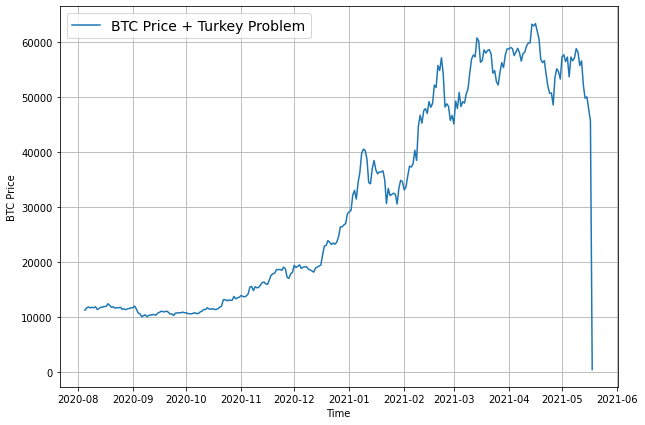

In [150]:
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=btc_timesteps_turkey, 
                 values=btc_price_turkey, 
                 format="-", 
                 label="BTC Price + Turkey Problem", 
                 start=2500)

In [151]:
# Create train and test sets for turkey problem data
full_windows, full_labels = make_windows(np.array(btc_price_turkey), window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

X_train, X_test, y_train, y_test = make_train_test_splits(full_windows, full_labels)
len(X_train), len(X_test), len(y_train), len(y_test)

(2224, 556, 2224, 556)

### Building a turkey model (model to predict on turkey data)

In [152]:


# Clone model 1 architecture for turkey model and fit the turkey model on the turkey data
turkey_model = tf.keras.models.clone_model(model_1)
turkey_model._name = "Turkey_Model"
turkey_model.compile(loss="mae",
                     optimizer=tf.keras.optimizers.Adam())
turkey_model.fit(X_train, y_train,
                 epochs=100,
                 verbose=0,
                 validation_data=(X_test, y_test),
                 callbacks=[create_model_checkpoint(turkey_model.name)])
     


In [153]:
# Evaluate turkey model on test data
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 3ms/step - loss: 812.9971


812.9970703125

In [154]:
# Load best model and evaluate on test data
turkey_model = tf.keras.models.load_model("model_experiments/Turkey_Model/")
turkey_model.evaluate(X_test, y_test)

18/18 [==============================] - 0s 2ms/step - loss: 640.4471


640.4471435546875

In [155]:
# Make predictions with Turkey model
turkey_preds = make_preds(turkey_model, X_test)
turkey_preds[:10]

18/18 [==============================] - 0s 2ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8843.627, 8792.954, 9064.842, 8772.202, 8748.486, 8758.181,
       8674.683, 8527.191, 8470.379, 8540.19 ], dtype=float32)>

In [156]:
# Evaluate turkey preds
turkey_results = evaluate_preds(y_true=y_test,
                                y_pred=turkey_preds)
turkey_results

{'mae': 17124.666,
 'mse': 614074600.0,
 'rmse': 23705.145,
 'mape': 121.30342,
 'mase': 26.500475}

In [157]:
model_1_results

{'mae': 567.00775,
 'mse': 1166101.1,
 'rmse': 1079.8616,
 'mape': 2.5331767,
 'mase': 0.9960756}

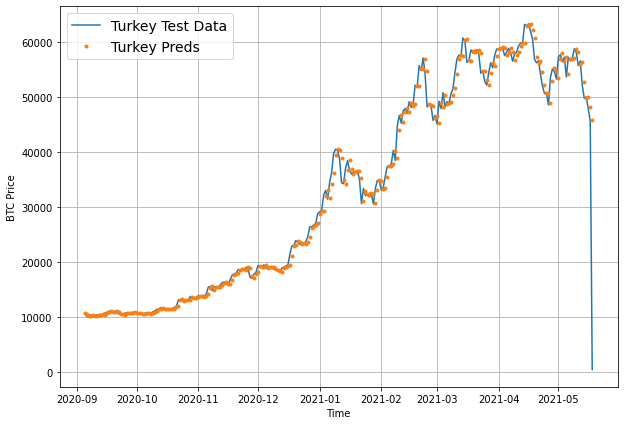

In [158]:
plt.figure(figsize=(10, 7))
# plot_time_series(timesteps=btc_timesteps_turkey[:split_size], values=btc_price_turkey[:split_size], label="Train Data")
offset=300
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):], 
                 values=btc_price_turkey[-len(y_test):], 
                 format="-", 
                 label="Turkey Test Data", start=offset)
plot_time_series(timesteps=btc_timesteps_turkey[-len(X_test):],
                 values=turkey_preds, 
                 label="Turkey Preds", 
                 start=offset);
     

# Compare Models

In [160]:

# Compare different model results (w = window, h = horizon, e.g. w=7 means a window size of 7)
model_results = pd.DataFrame({"naive_model": naive_result,
                              "model_1_dense_w7_h1": model_1_results,
                              "model_2_dense_w30_h1": model_2_results,
                              "model_3_dense_w30_h7": model_3_results,
                              "model_4_CONV1D": model_4_results,
                              "model_5_LSTM": model_5_results,
                              "model_6_multivariate": model_6_results,
                              "model_8_NBEATs": model_7_results,
                              "model_9_ensemble": ensemble_results,
                              "model_10_turkey": turkey_results}).T
model_results.head(10)

,mae,mse,rmse,mape,mase
naive_model,567.980225,1.147547e+06,1071.236206,2.516525,0.999570
model_1_dense_w7_h1,567.007751,1.166101e+06,1079.861572,2.533177,0.996076
model_2_dense_w30_h1,626.779053,1.357349e+06,1165.053345,2.788610,1.095616
model_3_dense_w30_h7,1224.352783,5.288586e+06,1414.354126,5.561237,2.178667
model_4_CONV1D,570.112732,1.183712e+06,1087.985107,2.553893,1.001530
model_5_LSTM,598.851379,1.274604e+06,1128.983398,2.703526,1.052016
model_6_multivariate,566.021851,1.162289e+06,1078.095093,2.536843,0.994344
model_8_NBEATs,580.992615,1.184513e+06,1088.353394,2.665199,1.020643
model_9_ensemble,568.775208,1.142458e+06,1068.858276,2.574807,0.999180
model_10_turkey,17124.666016,6.140746e+08,23705.144531,121.303421,26.500475


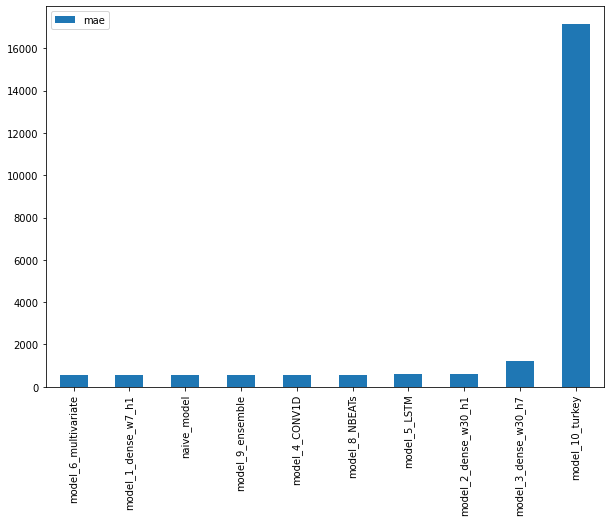

In [161]:
# Sort model results by MAE and plot them
model_results[["mae"]].sort_values(by="mae").plot(figsize=(10, 7), kind="bar");
   